


# <center> Classification KNN</center>
*Goubet Victor<br>
Graff Thomas*<br>
TD D

*Ce document a été rédigé dans le but de garder une trace de ce travail. Il est donc exaustif et retrace toutes les étapes de notre démarche*

# Partie I


### Prepatation des données
On commence par importer les librairies necessaires :

In [2]:
import pandas as pd

from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import numpy as np
import matplotlib.pyplot as plt

On importe les données :

In [3]:
data= pd.read_csv('data.csv',sep=';',header=None)

Ici on stock dans le vecteur X les colonnes correspondant aux classe et dans 
Y celles correspondant aux etiquettes

In [4]:
X=data[data.columns[:-1]].values
Y=data[data.columns[-1]].to_numpy()

labels_Class=np.unique(Y)

On va maintenant normaliser nos donnèes. Cela permettra de réduire l'impact des donnèes erronées. Cela revient donc à diviser nos données par l'ecart type et soustraire la moyenne. Dans un soucis de rapidité on utilise ici le scaler fournis par sklearn.

In [5]:
std_scale = preprocessing.StandardScaler().fit(X)
X_normalize = std_scale.transform(X)

On utilise le module Sklearn pour séparer nos données en un jeux d'entrainement et un autre de test. <br>
La separation est plus efficace car il procéde à un mélange aléatoire avant de séparer les données. On prend ici 20% des données en données de test.

In [6]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_normalize, Y,test_size=0.2,random_state=4871)
#On fixe le random state afin d'avoir toujours la même distribution aléatoire

### Definition du Model

In [6]:
class KNN:
    
    def __init__(self,k=1):
        self.k=k
        
    def Train(self,X_train,Y_train):
        self.X_train=X_train
        self.Y_train=Y_train
        
    def Distance(self,ptTest,ptTrain):
        #On commence par définir une fonction de calcul de distance. Ici on choisit la distance euclidienne
        distance=0
        for k in range(len(ptTrain)):
            distance+=(ptTrain[k]-ptTest[k])**2
        return np.sqrt(distance)
    
    
    def GetLabel(self,instance):
        #On definit la fonction GetLabel permettant de prédir l'étiquette d'une instance
        #On récupére la distance de l'instance à chaque point
        distances=[self.Distance(instance,x) for x in self.X_train ]
        #On récupére les index de la liste triée
        indexes=np.argsort(distances)[:self.k]
        #On récupére les label triés selon ces indexs
        Top_Neighbours=np.array([self.Y_train[i] for i in indexes])

        #On renvoie le plus présent
        return max(labels_Class,key=lambda x:np.sum(Top_Neighbours==x))

    def GetLabels(self,X):
        #On récupére ici le label de chaque instance
        labels=[self.GetLabel(x) for x in X]
        return np.array(labels)
    
    def Precision(self,X_test,Y_test,MC):
        #On compare nos label estimés aux réel labels et on en déduit une precision
        labels=self.GetLabels(X_test)
        precision=np.sum(labels==Y_test)/len(labels)*100
        
        #Mode Affichage
        if MC:
            fig = plt.figure(figsize=(5,5))
            ax = fig.add_subplot(111)
            im = ax.imshow(confusion_matrix(Y_test,labels))
            fig.colorbar(im)
            plt.title("Matrice de confusion")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
        
        return precision

### Test du model

On test notre fonction avec le resultat labels utilisant k=2 <br> On affiche le pourcentage de precision et la matrice de confusion

86.11111111111111

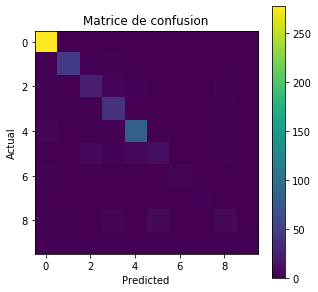

In [7]:
model=KNN(2)
model.Train(X_train,Y_train)
model.Precision(X_test,Y_test,True)

En prenant un k aléaoirement on a ici un score de 86.11
### Optimisation du model

Maintenant que notre modèle est construit et qu'il nous fournit des resultats acceptables, nous pouvons essayer de régler le paramètre k afin d'augmenter notre score.
Pour cela on va séparer nos données non pas en deux mais en 3 sets. Un pour l'entrainement, un pour la validation (optimisation de k ) et un dernier pour le test final.

Cependant, plusieurs découpages de nos donnèes sont possibles pour choisir notre set de validation. On va donc utiliser la méthode de **cross validation** qui permet d'explorer tout les découpages possibles pour notre set et de retourner à chaque fois son score.<br>
Ici on va utilise le découpage des **KFolds**

In [8]:
def CrossValidation(k,X_train,Y_train,nFolds=5):
    scoresValidation=[]
    
    model=KNN(k)
    #On découpe en n folds notre data set
    X_Splits=np.array_split(X_train,nFolds)
    Y_Splits=np.array_split(Y_train,nFolds)
    
    #Pour chaque fold on va mettre à jour le set d'entrainement et de validation et on va calculer le score
    for i in range(nFolds):
        print("\nCalcul du fold n°(",i+1,"/",nFolds,")..")
        X_validation=X_Splits[i]
        Y_validation=Y_Splits[i]
        X_newTrain=np.concatenate(np.delete(X_Splits,i,0))
        Y_newTrain=np.concatenate(np.delete(Y_Splits,i,0))
        
        model.Train(X_newTrain,Y_newTrain)
        scoresValidation.append(model.Precision(X_validation,Y_validation,False))
        
    #On renvoi le tableau des scores
    return np.array(scoresValidation)
        
        

On peut maintenant tester notre methode pour k=2 et 5 folds

In [9]:
scoresValidation=CrossValidation(2,X_train,Y_train)
print("\nScore sur le set de validation pour chaque fold :\n",scoresValidation)
print("\nMoyenne des scores:",scoresValidation.mean())


Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

Score sur le set de validation pour chaque fold :
 [83.51409978 85.90021692 84.13043478 86.30434783 83.91304348]

Moyenne des scores: 84.7524285579553


Nous sommes maintenant prêt à tester pour differents valeures de k <br> On va tracer le score sur le set de validation en fonction de k. 

In [10]:

def Optimise(listeK,X_train,Y_train):
    scoresValidation=[]
    
    #On applique pour chaque k la méthode de validation croisée
    for k in listeK:
        print("===========================Test k=",k,"==================================")
        
        #On prend ici la moyenne des scores de chaque fold
        accuracy=CrossValidation(k,X_train,Y_train,5).mean()
        scoresValidation.append(accuracy)
        print("\n→ Accuracy =",accuracy)
    return scoresValidation
    

On applique notre fonction pour k entre 1 et 14 et on trace le resultat.

In [11]:
listeK=range(1,15)
scoresValidation=Optimise(listeK,X_train,Y_train)

===========================Test k= 1 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 84.40450815806847
===========================Test k= 2 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 84.7524285579553
===========================Test k= 3 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 84.7524285579553
===========================Test k= 4 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 85.9

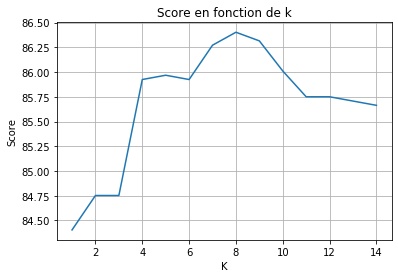

In [12]:
plt.plot(listeK,scoresValidation)
plt.title("Score en fonction de k")
plt.ylabel("Score")
plt.xlabel("K")
plt.grid()

On peut voir ici que l'on obtient des scores haut pour k=7-8-9. Cependant un k pair peu mener à des votes égalitaires. On choisit donc k=9 qui est légérement plus haut que k=7.
### Test final

88.36805555555556

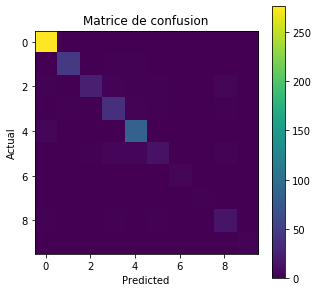

In [13]:
model=KNN(9)
model.Train(X_train,Y_train)
model.Precision(X_test,Y_test,True)

On obtient finalement un score de **88.37**.

### Ameliorations

Une première amélioration serait d'optimiser les calculs afins qu'ils soient plus rapides.Plusieurs techniques ont déja été imaginées comme l'utilisation d'une ACP pour réduire le nombre de dimensions pour la distance ou encore utiliser des arbres de recherche pour trouver des "presques voisin"<br>
Une deuxième amélioration non nègligeable serait d'optimiser un deuxième hyper paramètre qui est le calcul de la distance en utilisant par exemple une distance discriminante avec des poids comme celle de mahalanobis. Cependant cela reviendrait à chercher la solution dans une grille (distance en ligne et k en colonne) soit environs 5x15 possibilitées (5 types de distance et on test 15 k) ce qui prendrait enormement de temps avec une version non optimisée.<br> On revient donc à la première amélioration..

# Partie II
Nous avons maintenant un deuxième dataset à diposition. Nous avons choisit d'utiliser ce dataset afin d'agrandir nos données d'aprentissage. En effet un plus grand nombre de données d'entrainement améliorera la precision de notre model (on peut d'ailleurs le voir sur les learning curve avec sklearn). <br> Dans un premier temps nous allons tester notre model sur ces datas voir si tout se passe bien, puis, nous fusionnerons les deux datasets et nous l'entrainerons avec ces nouvelles données.

### Test sur le nouveau dataset

*on prépare nos donnèes*

In [7]:
data2= pd.read_csv('preTest.csv',sep=';',header=None) #On charge

#On sépare les etiquettes
X2=data2[data2.columns[:-1]].values
Y2=data2[data2.columns[-1]].to_numpy()

#On normalise
std_scale2 = preprocessing.StandardScaler().fit(X2)
X2_normalize = std_scale2.transform(X2)

On regarde le score pour notre nouveau dataSet.

88.33333333333333

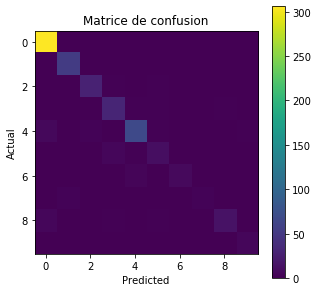

In [15]:
model2=KNN(9)
model2.Train(X_normalize,Y)
model2.Precision(X2_normalize,Y2,True)

On obtient ici avec le model optimisé un score de **88.33**. Tout semble donc marcher.<br>
On a ici "fité" nos données sur l'entièreté du premier dataset afin d'avoir plus de données d'entrainement. Cela a permis d'avoir un score légérement meilleur et garanti donc que nous ne subissons pas de phénoméne de **double descent**.
### Fusion des dataSets
Fusionnons maintenant les datasets afin d'augmenter encore notre precision d'optimisation

In [8]:
X3_normalize=np.concatenate([X_normalize,X2_normalize])
Y3=np.concatenate([Y,Y2])

X_train3, X_test3, Y_train3, Y_test3 = model_selection.train_test_split(X3_normalize, Y3,test_size=0.2,random_state=4871)

On ré-optimise le model avec le nouveau set d'entrainement agrandit

In [17]:
scoresValidation3=Optimise(listeK,X_train3,Y_train3)

===========================Test k= 1 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 85.44269790630692
===========================Test k= 2 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 84.97526574790437
===========================Test k= 3 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 86.05311083269828
===========================Test k= 4 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 86

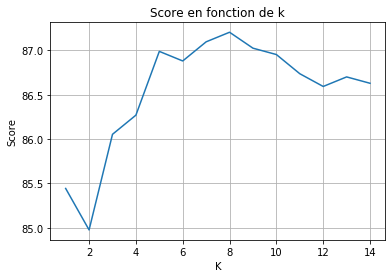

In [18]:
plt.plot(listeK,scoresValidation3)
plt.title("Score en fonction de k")
plt.ylabel("Score")
plt.xlabel("K")
plt.grid()

On voit ici qu'avec plus de données, le réglage k=7 semble plus optimal que k=9 (on ignore toujours k=8 car il est pair). <br>
On va donc prendre cette valeure.

87.5

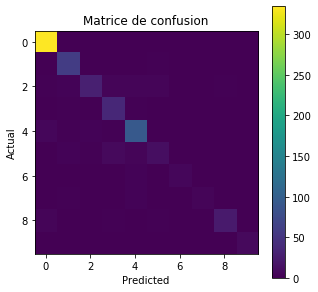

In [19]:
model3=KNN(7)
model3.Train(X_train3,Y_train3)
model3.Precision(X_test3,Y_test3,True)

On obtient alors sur notre set de test un score de **87.5** 

# Partie III
Nous allons maintenant tester notre model sur un dataset inconnu dont on ne connait pas les etiquettes.<br>
On va commencer par importer les donnèes: 

In [30]:
datafinal= pd.read_csv('finalTest.csv',sep=';',header=None)
Xfinal=datafinal.values

std_scaleFinal = preprocessing.StandardScaler().fit(Xfinal)
Xfinal_normalize = std_scaleFinal.transform(Xfinal)

On définit ensuite notre model final en lui donnant la totalité des données du dataset 1 et 2 comme données d'entrainement pour les mêmes raisons qu'énoncées plus haut.

In [31]:
modelFinal=KNN(7)
modelFinal.Train(X3_normalize,Y3)

### Enregistrement des labels
On enregistre les labels dans un fichier texte

In [32]:
def Save(labels):
    with open("GOUBET_GRAFF.txt",'w') as f:
        for label in labels:
            f.write(label+"\n")

In [33]:
labels=modelFinal.GetLabels(Xfinal_normalize)
Save(labels)

# Comparaison avec le model de Sklearn

### Optimisation de k

In [9]:
from sklearn.model_selection  import validation_curve
from sklearn.neighbors import KNeighborsClassifier

On utilise ici le model KNN et la cross validation fournis par Sklearn.

In [12]:
#On définit le model
model=KNeighborsClassifier()
#Pour chaque k, on récupère les scores sur le set d'entrainement et de validation
interval=np.arange(1,30)
ScoreTrain,ScoreValidation=validation_curve(model,X_train3,Y_train3,'n_neighbors',interval,cv=5)
#On ne garde que les moyennes (comme expliqué plus haut)
ScoreValidation_Mean=ScoreValidation.mean(axis=1)
ScoreTrain_Mean=ScoreTrain.mean(axis=1)

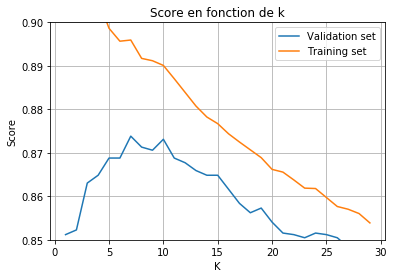

In [13]:
plt.plot(interval,ScoreValidation_Mean,label='Validation set')
plt.plot(interval,ScoreTrain_Mean,label='Training set')
plt.legend()
plt.title("Score en fonction de k")
plt.ylabel("Score")
plt.xlabel("K")
plt.ylim(0.85,0.9)
plt.grid()
plt.show()

- On a également tracé ici la courbe de score pour le training set. Cela nous permet de repérer les zones de suraprentissage (grand score sur le train et faible sur le validation), typiquement pour k< 5 ici.
- On obtient donc ici k=7



### GridSearch
On va ici utiliser la méthode grid search qui procède toujours par cross validation mais qui va également optimiser tout les autres hypers parmètres (ici k et distances).

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
#On teste ici pour 5 distances
V1=np.cov(X_train3.T)
V2=V1.diagonal()

paramétres = [
    {'n_neighbors':interval , 'metric': ['euclidean', 'minkowski','chebyshev']},
    
    {'n_neighbors': interval,'algorithm':['brute'], 'metric': ['mahalanobis'],'metric_params': [{'V':V1 }]},
    {'n_neighbors': interval,'algorithm':['brute'], 'metric': ['seuclidean'],'metric_params': [{'V':V2 }]}
]

#Le model etant ici plus performant on peu se permettre de spliter en 10 plutot qu'en 5
grid=GridSearchCV(KNeighborsClassifier(),paramétres,cv=10)
grid.fit(X_train3,Y_train3)
print(grid.best_params_)

{'metric': 'euclidean', 'n_neighbors': 7}


On s'aperçoit qu'ici la distance euclidienne est la plus efficace et que k=7 reste donc la meilleure option. On trouve donc le même k trouvé plus haut.<br>
On remarque d'ailleurs que l'on a bien fait de ne pas choisir une distance avec des poids comme mahalanobis qui pourtant parait plus performante de part sa discrimination des points éloignés et non similaires mais qui pourtant apporte un moins bon score.

In [16]:
model=grid.best_estimator_
model.score(X_test3,Y_test3)

0.875

On obtient avec ce model une precision de **87.5** sur le set de test qui est égal au score trouvé plus haut.<br>
On peut donc conclure que notre model est valable.